In [5]:
from statsmodels.stats.proportion import proportion_confint
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from datetime import date
import datetime
import csv
import baltic as bt
import collections
# from Bio.Alphabet import IUPAC
# from pySankey.sankey import sankey
import math
import collections
import datetime as dt

import os
import csv
from Bio import SeqIO
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import collections
import numpy as np
import pandas as pd
import datetime
from datetime import date

# import skbio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.lines as mlines
import collections
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.collections import PatchCollection
#from epiweeks import Week, Year
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 18}
from matplotlib.lines import Line2D

mpl.rcParams.update({'font.size': 25})

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

plt.rcParams['font.family'] = 'Helvetica'

In [6]:
def get_node_states_all_sites(directory,state_file,alignment):
    
    #returns a dict keys off 1-based positions in the genome
    #and the value is a list of tuples (id, base) at a given node
    # allows you to look up for a given site what the base is for a
    #given internal node or tip
    
    node_states = collections.defaultdict(list)
    c = 0
    
    ## first the reconstructed nodes
    with open(f"{directory}/{state_file}","r") as f:
        for l in f:

            if not l.startswith("#"):
                c+=1
                try:
                    node,site,state,probA,probC,probG,probT = l.rstrip("\n").split("\t")
                except:
                    print(l)
                    break
                if node != "Node":
                    if state not in ["N","-"]:
                        node_states[site].append((node,state))
                    else:
                        node_states[site].append((node,""))
    ## now the tips
    for record in SeqIO.parse(f"{directory}/{alignment}","fasta"):
        for site in node_states:
            index = int(site)-1
            base = record.seq[index]
            if base in ["T","C","A","G"]:
                node_states[site].append((record.id,base))
            else:
                node_states[site].append((record.id,""))
                
    return node_states

def get_header_str(dict_values):
    header_str = ""
    for i in sorted(dict_values, key = lambda i : i[0]):
        header_str += f"{i[0]},"
    header_str = header_str.rstrip(",")
    return header_str
    
    
def find_what_sites_vary_unambiguously(node_states,outfile):
    header_str = get_header_str(node_states["1"])
    
    with open(outfile,"w") as fw:
        fw.write(f"site,{header_str}\n")

        for site in node_states:
            info = node_states[site]
            
            # get the set of unique bases at a given site
            count = set([i[1] for i in info if i[1]])
            
            #if there's more than one
            if len(count)>1:
                
                #needs to be kep consistent with header str
                info = sorted(info, key = lambda i : i[0])
                base_str = ""
                for i in info:
                    base_str += f"{i[1]},"
                    
                base_str = base_str.rstrip(",")
                fw.write(f"{site},{base_str}\n")
    
def load_unambiguous_varying_sites(infile):
    node_states_diff = collections.defaultdict(dict)
    with open(infile,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            site = row["site"]
            for col in row:
                if col != "site":
                    node_states_diff[row["site"]][col] = row[col]
    return node_states_diff

def map_site_changes_to_branches(treefile, outfile,node_states,node_states_diff): 
    my_tree=bt.loadNewick(treefile,absoluteTime=False)
    last_node = ""
    current_node = ""

    with open(outfile,"w") as fw:
        fw.write("parent,child,site,snp,dimer\n")

        for k in my_tree.Objects:
            if k.branchType == 'leaf':
                current_node = k
                current_node.traits["label"]=k.name
            else:
                current_node = k

            if last_node:
                node_name = current_node.traits["label"]
                parent_name = current_node.parent.traits["label"]
                snps = []
                for site in node_states_diff:
                    node_base = node_states_diff[site][node_name]
                    parent_base = node_states_diff[site][parent_name]

                    if node_base != parent_base:
                        if node_base in ["A","C","G","T"] and parent_base in ["A","C","G","T"]:
                            snp = f"{parent_base}->{node_base}"
                            snps.append(snp)
                            if snp == "G->A":
                                dimer_site = f"{int(site)+1}"
                                dimer_base = ""

                                for i in node_states[dimer_site]:
                                    if i[0] == parent_name:
                                        dimer_base = i[1]
                                dimer = f"{parent_base}{dimer_base}"
                            elif snp == "C->T":
                                dimer_site = f"{int(site)-1}"
                                dimer_base = ""

                                for i in node_states[dimer_site]:
                                    if i[0] == parent_name:
                                        dimer_base = i[1]
                                dimer = f"{dimer_base}{parent_base}"
                            else:
                                dimer = ""
                            fw.write(f"{parent_name},{node_name},{site},{snp},{dimer}\n")

            last_node = current_node

def read_in_branch_snps(branch_snps):
    branch_snps_dict = collections.defaultdict(list)
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            branch = f"{row['parent']}_{row['child']}"
            branch_snps_dict[branch].append((row['site'],row['snp'],row['dimer'])) 
    return branch_snps_dict

def get_branch_snps_sites(branch_snps):
    all_snps = collections.Counter()
    branch_snps_dict = collections.defaultdict(list)
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            all_snps[int(row["site"])]+=1

            branch_snps_dict[int(row['site'])].append([row['parent'],row['child'],row['snp'],row['dimer']])
    
    homoplasies = {}
    for k in all_snps:
        if all_snps[k]>1:
            homoplasies[k] = all_snps[k]
            
    print(len(homoplasies))
    print(homoplasies)
    return branch_snps_dict,homoplasies
    

def get_acc_to_metadata_map(metadata):
    acc_dict = {}
    with open(metadata,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                acc_dict[row["accession"]] = row
            except:
                try:
                    acc_dict[row["\ufeffaccession"]] = row
                except:
                    pass
                
    return acc_dict

In [7]:
def make_reconstruction_tree_figure(outfile,branch_snps,treefile,width,height):
    
    branch_snps_dict = read_in_branch_snps(branch_snps)
    print(len(branch_snps_dict),"snps")
#     acc_dict = get_acc_to_metadata_map(metadata)
#     print(len(acc_dict))        
    
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(width,height),facecolor='w')
    
    col_dict = {

 "Bo": "#A0CBE8",
    "Bonthe": "#F1CE63",
    "Bombali": "#4E79A7",
    "Kambia": "#499894",
    "koinadugu": "#79706E",
    "Koinadugu": "#79706E",
    "Kailahun": "#8CD17D",
    "Kenema": "#B6992D",
     "Tongo": "#B6992D",
    "Kono": "#F28E2B",
    "PortLoko": "#86BCB6",
    "Port-Loko": "#86BCB6",
    "Portloko": "#86BCB6",
    "Pujehun": "#FFBE7D",
    "Tonkolili": "#59A14F",
    "WesternRural": "#BAB0AC",
    "WesternAreaRural": "#BAB0AC",
    "Freetown": "#E15759",
    "WesternUrban": "#E15759",
    "WesternAreaUrban":"#E15759",
    "Falaba": "#79706E",
    "nan": "#E15759",
}

 # Display label mapping
    display_names = {'koinadugu': 'Koinadugu'},
    display_names = {'nan': 'WesternUrban'},
    display_names = {'Tongo': 'Kenema'},
    display_names = {'Port-Loko': 'PortLoko'},
    display_names = {'Portloko': 'PortLoko'}

    
    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 100-30*k.height/my_tree.treeHeight ## size of tips
    s_func=lambda k: 250-20*k.height/my_tree.treeHeight ## size of tips
    c_func=lambda k: col_dict[k.name.split('|')[-3]] if k.name.split('|')[-3] in col_dict else '#A412FF'

    increment = my_tree.treeHeight/150
    my_tree.plotTree(ax,x_attr=x_attr) ## plot branches
    my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'
    

    
    
    for k in my_tree.Objects:
        current_node = k
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name

        node_name = current_node.traits["label"]
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in branch_snps_dict:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment
            for s in branch_snps_dict[branch_name]:
                site,snp,dimer = s
                if snp == "G->A":
                    if dimer in ["GA"]:
                        snps.append((1,"#FFB703"))
                    else:
                        snps.append((2,"#A9A9A9"))
                elif snp == "C->T":
                    if dimer in ["TC"]:
                        snps.append((1,"#FFB703"))
                    else:
                        snps.append((2,"#A9A9A9"))
                else:
                    snps.append((2,"#A9A9A9"))

            for snp in sorted(snps, key = lambda x : x[0]):
                plt.scatter([snp_placement],[k.y+1.5],color=snp[1],s=30)
                snp_placement += increment

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(axis='y',size=0)
    ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # Legend for countries with display mapping
    country_handles = []
    for code, color in col_dict.items():
        label = display_names.get(code, code)
        country_handles.append(Line2D([0], [0], marker='o', color='w', label=label,
                                      markerfacecolor=color, markersize=30))
    legend1 = ax.legend(handles=country_handles, title='District of origin',
                        bbox_to_anchor=(0.01, 0.6), loc='upper left')
    ax.add_artist(legend1)

    # Legend for SNP types
    snp_handles = [
        Line2D([0], [0], marker='o', color='w', label='APOBEC3 SNP',
               markerfacecolor='#FFB703', markersize=30),
        Line2D([0], [0], marker='o', color='w', label='Other SNP',
               markerfacecolor='#A9A9A9', markersize=30)
    ]
    ax.legend(handles=snp_handles, title='Mutation type',
              bbox_to_anchor=(0.01, 0.8), loc='upper left')

    # Save and display
    plt.savefig(f"/{outfile}.svg")
    plt.savefig(f"/{outfile}.png", bbox_inches='tight', transparent=True)
    plt.show()

221 snps


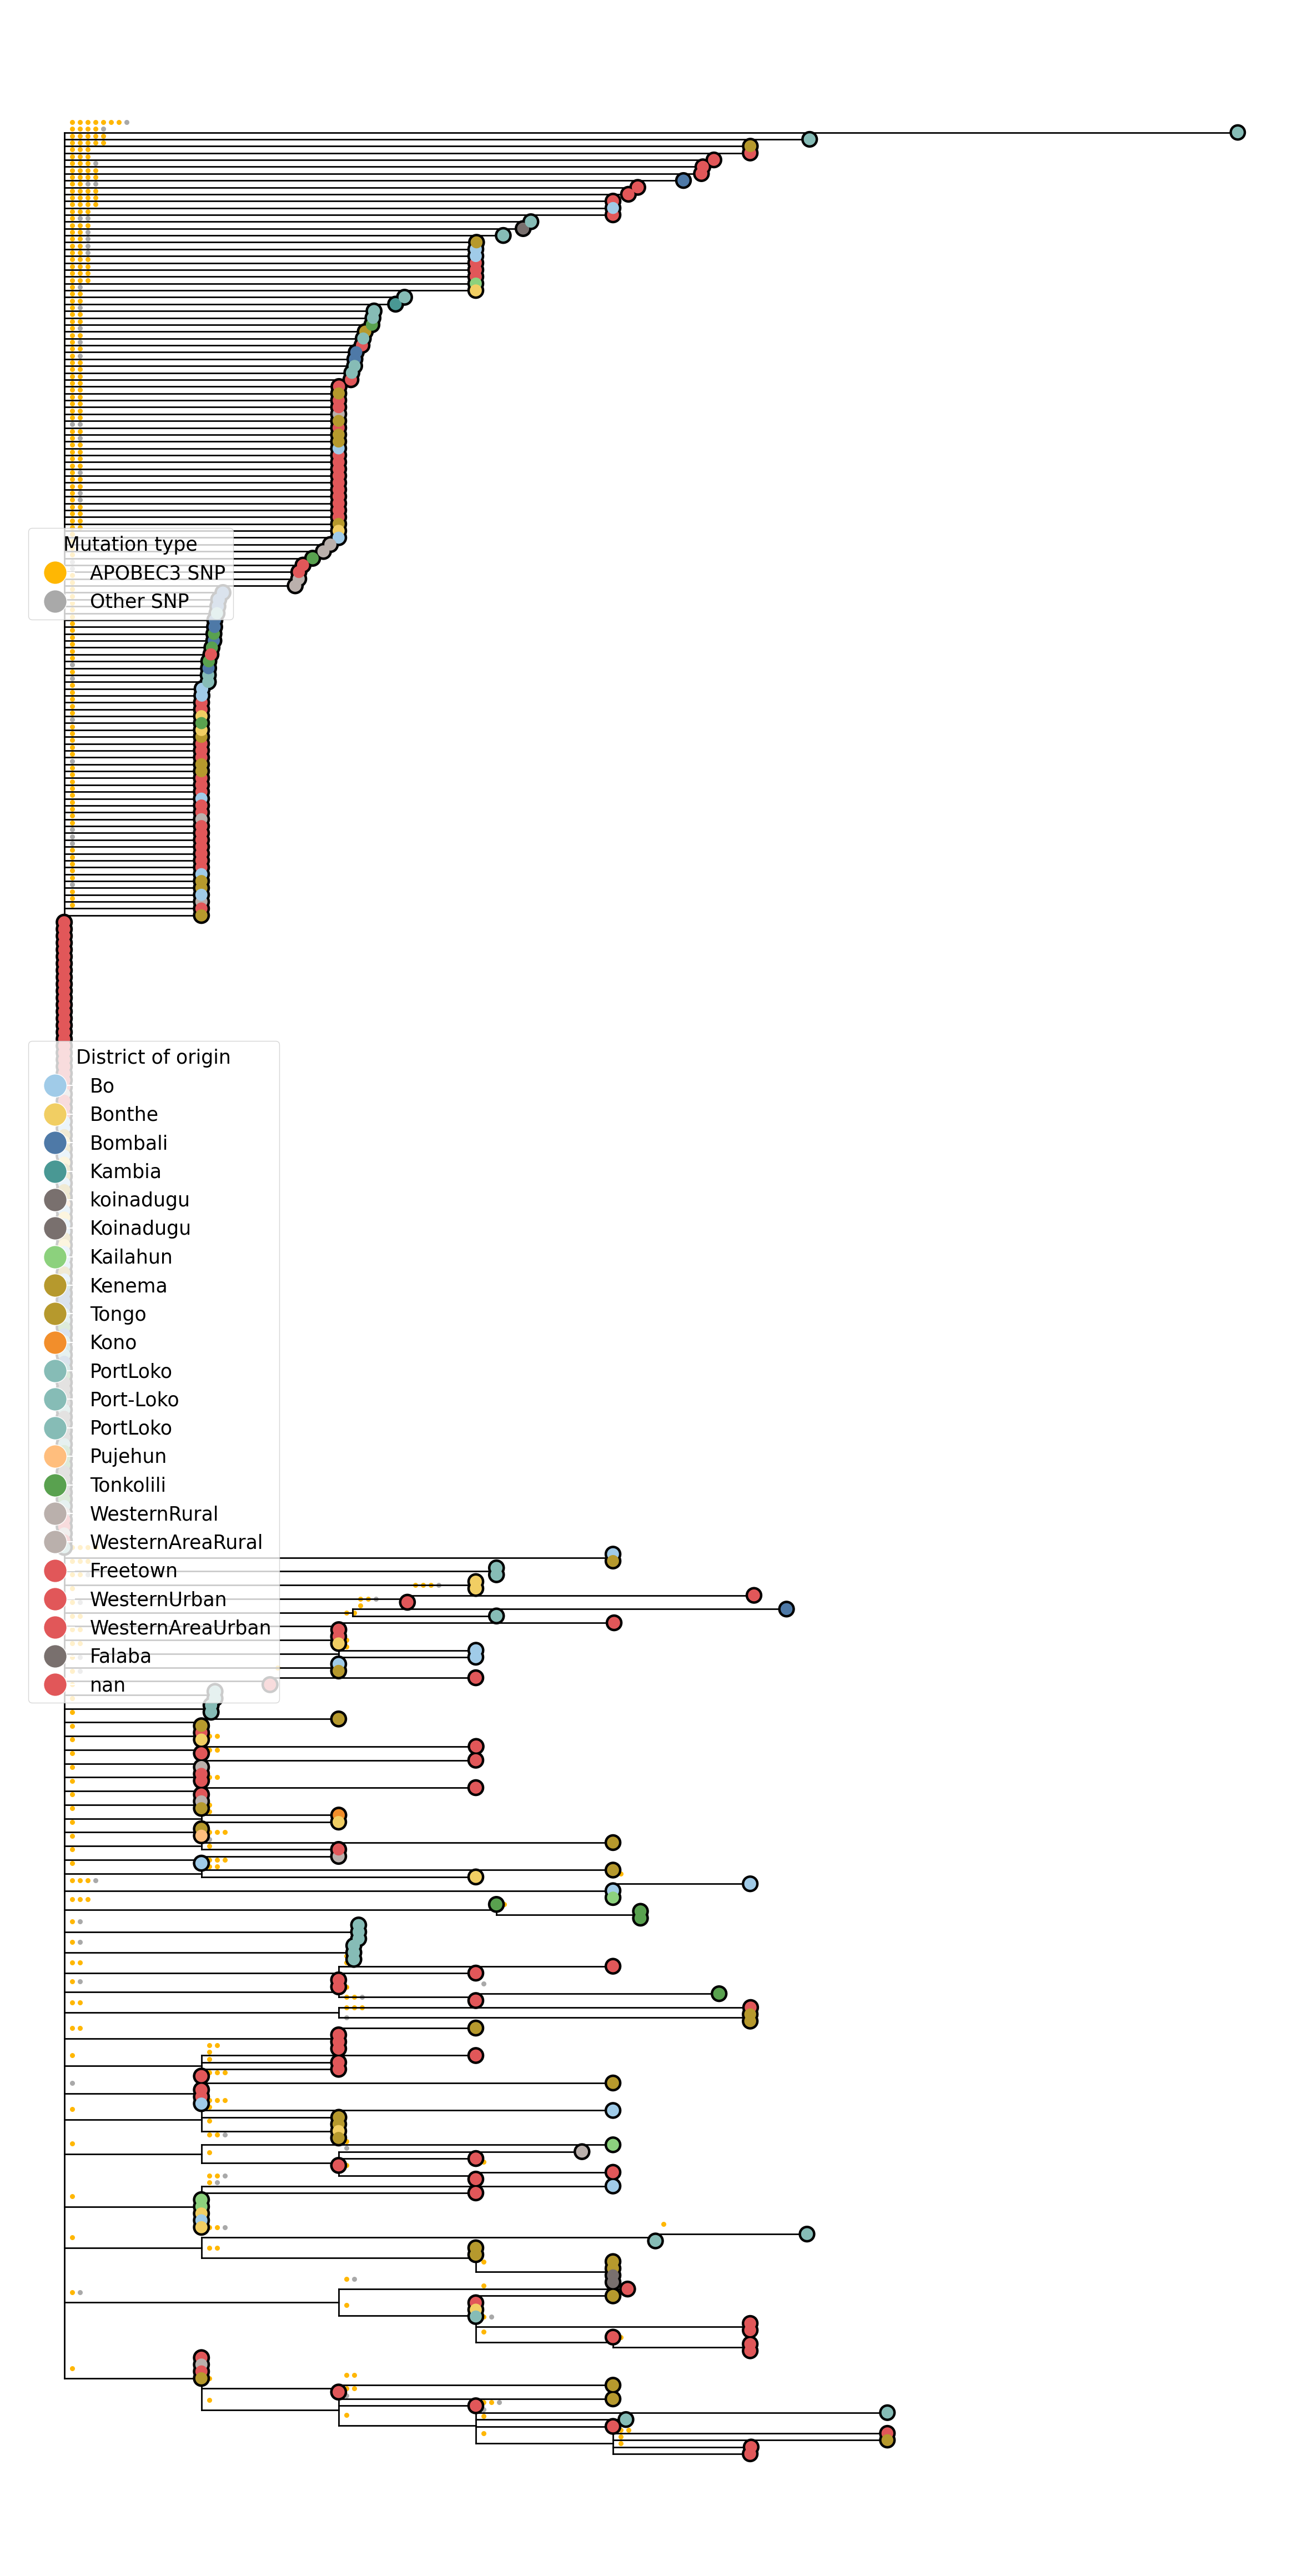

In [8]:
branch_snps = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Final+Mask+SLE+data+25Sept17/Complete+SLE+sequence+25sept18.tree.branch_snps.reconstruction.csv"
treefile ="/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Final+Mask+SLE+data+25Sept17/Complete+SLE+sequence+25sept18.tree"
make_reconstruction_tree_figure("/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Final+Mask+SLE+data+25Sept17/Complete+SLE+sequence+25sept18.labelled_tree",branch_snps,treefile,30,60)


In [15]:
def make_reconstruction_tree_figure(outfile,branch_snps,treefile,width,height):
    
    branch_snps_dict = read_in_branch_snps(branch_snps)
    print(len(branch_snps_dict),"snps")
#     acc_dict = get_acc_to_metadata_map(metadata)
#     print(len(acc_dict))        
    
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(width,height),facecolor='w')
    
    col_dict={
   'SLE':  '#9A031E',
   'Nigeria': '#E36414',
   'Congo':  '#A412FF',
   'Togo':   '#ff12ac',
   'Ghana':  '#003566',
   'Germany':'#219EBC',
   'USA':    '#007F5F',
   'Guinea': '#90BE6D'}
    
    # Display label mapping
    display_names = {'SLE': 'Sierra Leone'}

    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 250-30*k.height/my_tree.treeHeight ## size of tips
    s_func=lambda k: 250-20*k.height/my_tree.treeHeight ## size of tips
    c_func=lambda k: col_dict[k.name.split('|')[-2]] if k.name.split('|')[-2] in col_dict else '#A412FF'

    increment = my_tree.treeHeight/150
    my_tree.plotTree(ax,x_attr=x_attr) ## plot branches
    my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'
    

    
    
    for k in my_tree.Objects:
        current_node = k
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name

        node_name = current_node.traits["label"]
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in branch_snps_dict:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment
            for s in branch_snps_dict[branch_name]:
                site,snp,dimer = s
                if snp == "G->A":
                    if dimer in ["GA"]:
                        snps.append((1,"#FFB703"))
                    else:
                        snps.append((2,"#A9A9A9"))
                elif snp == "C->T":
                    if dimer in ["TC"]:
                        snps.append((1,"#FFB703"))
                    else:
                        snps.append((2,"#A9A9A9"))
                else:
                    snps.append((2,"#A9A9A9"))

            for snp in sorted(snps, key = lambda x : x[0]):
                plt.scatter([snp_placement],[k.y+1.5],color=snp[1],s=30)
                snp_placement += increment

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(axis='y',size=0)
    ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # Legend for countries with display mapping
    country_handles = []
    for code, color in col_dict.items():
        label = display_names.get(code, code)
        country_handles.append(Line2D([0], [0], marker='o', color='w', label=label,
                                      markerfacecolor=color, markersize=30))
    legend1 = ax.legend(handles=country_handles, title='Country',
                        bbox_to_anchor=(2.05, 1), loc='upper left')
    ax.add_artist(legend1)

    # Legend for SNP types
    snp_handles = [
        Line2D([0], [0], marker='o', color='w', label='APOBEC3 SNP',
               markerfacecolor='#FFB703', markersize=30),
        Line2D([0], [0], marker='o', color='w', label='Other SNP',
               markerfacecolor='#A9A9A9', markersize=30)
    ]
    ax.legend(handles=snp_handles, title='',
              bbox_to_anchor=(1.05, 0.6), loc='upper left')

    # Save and display
    plt.savefig(f"{outfile}.svg")
    plt.savefig(f"{outfile}.png", bbox_inches='tight', transparent=True)
    plt.show()

468 snps


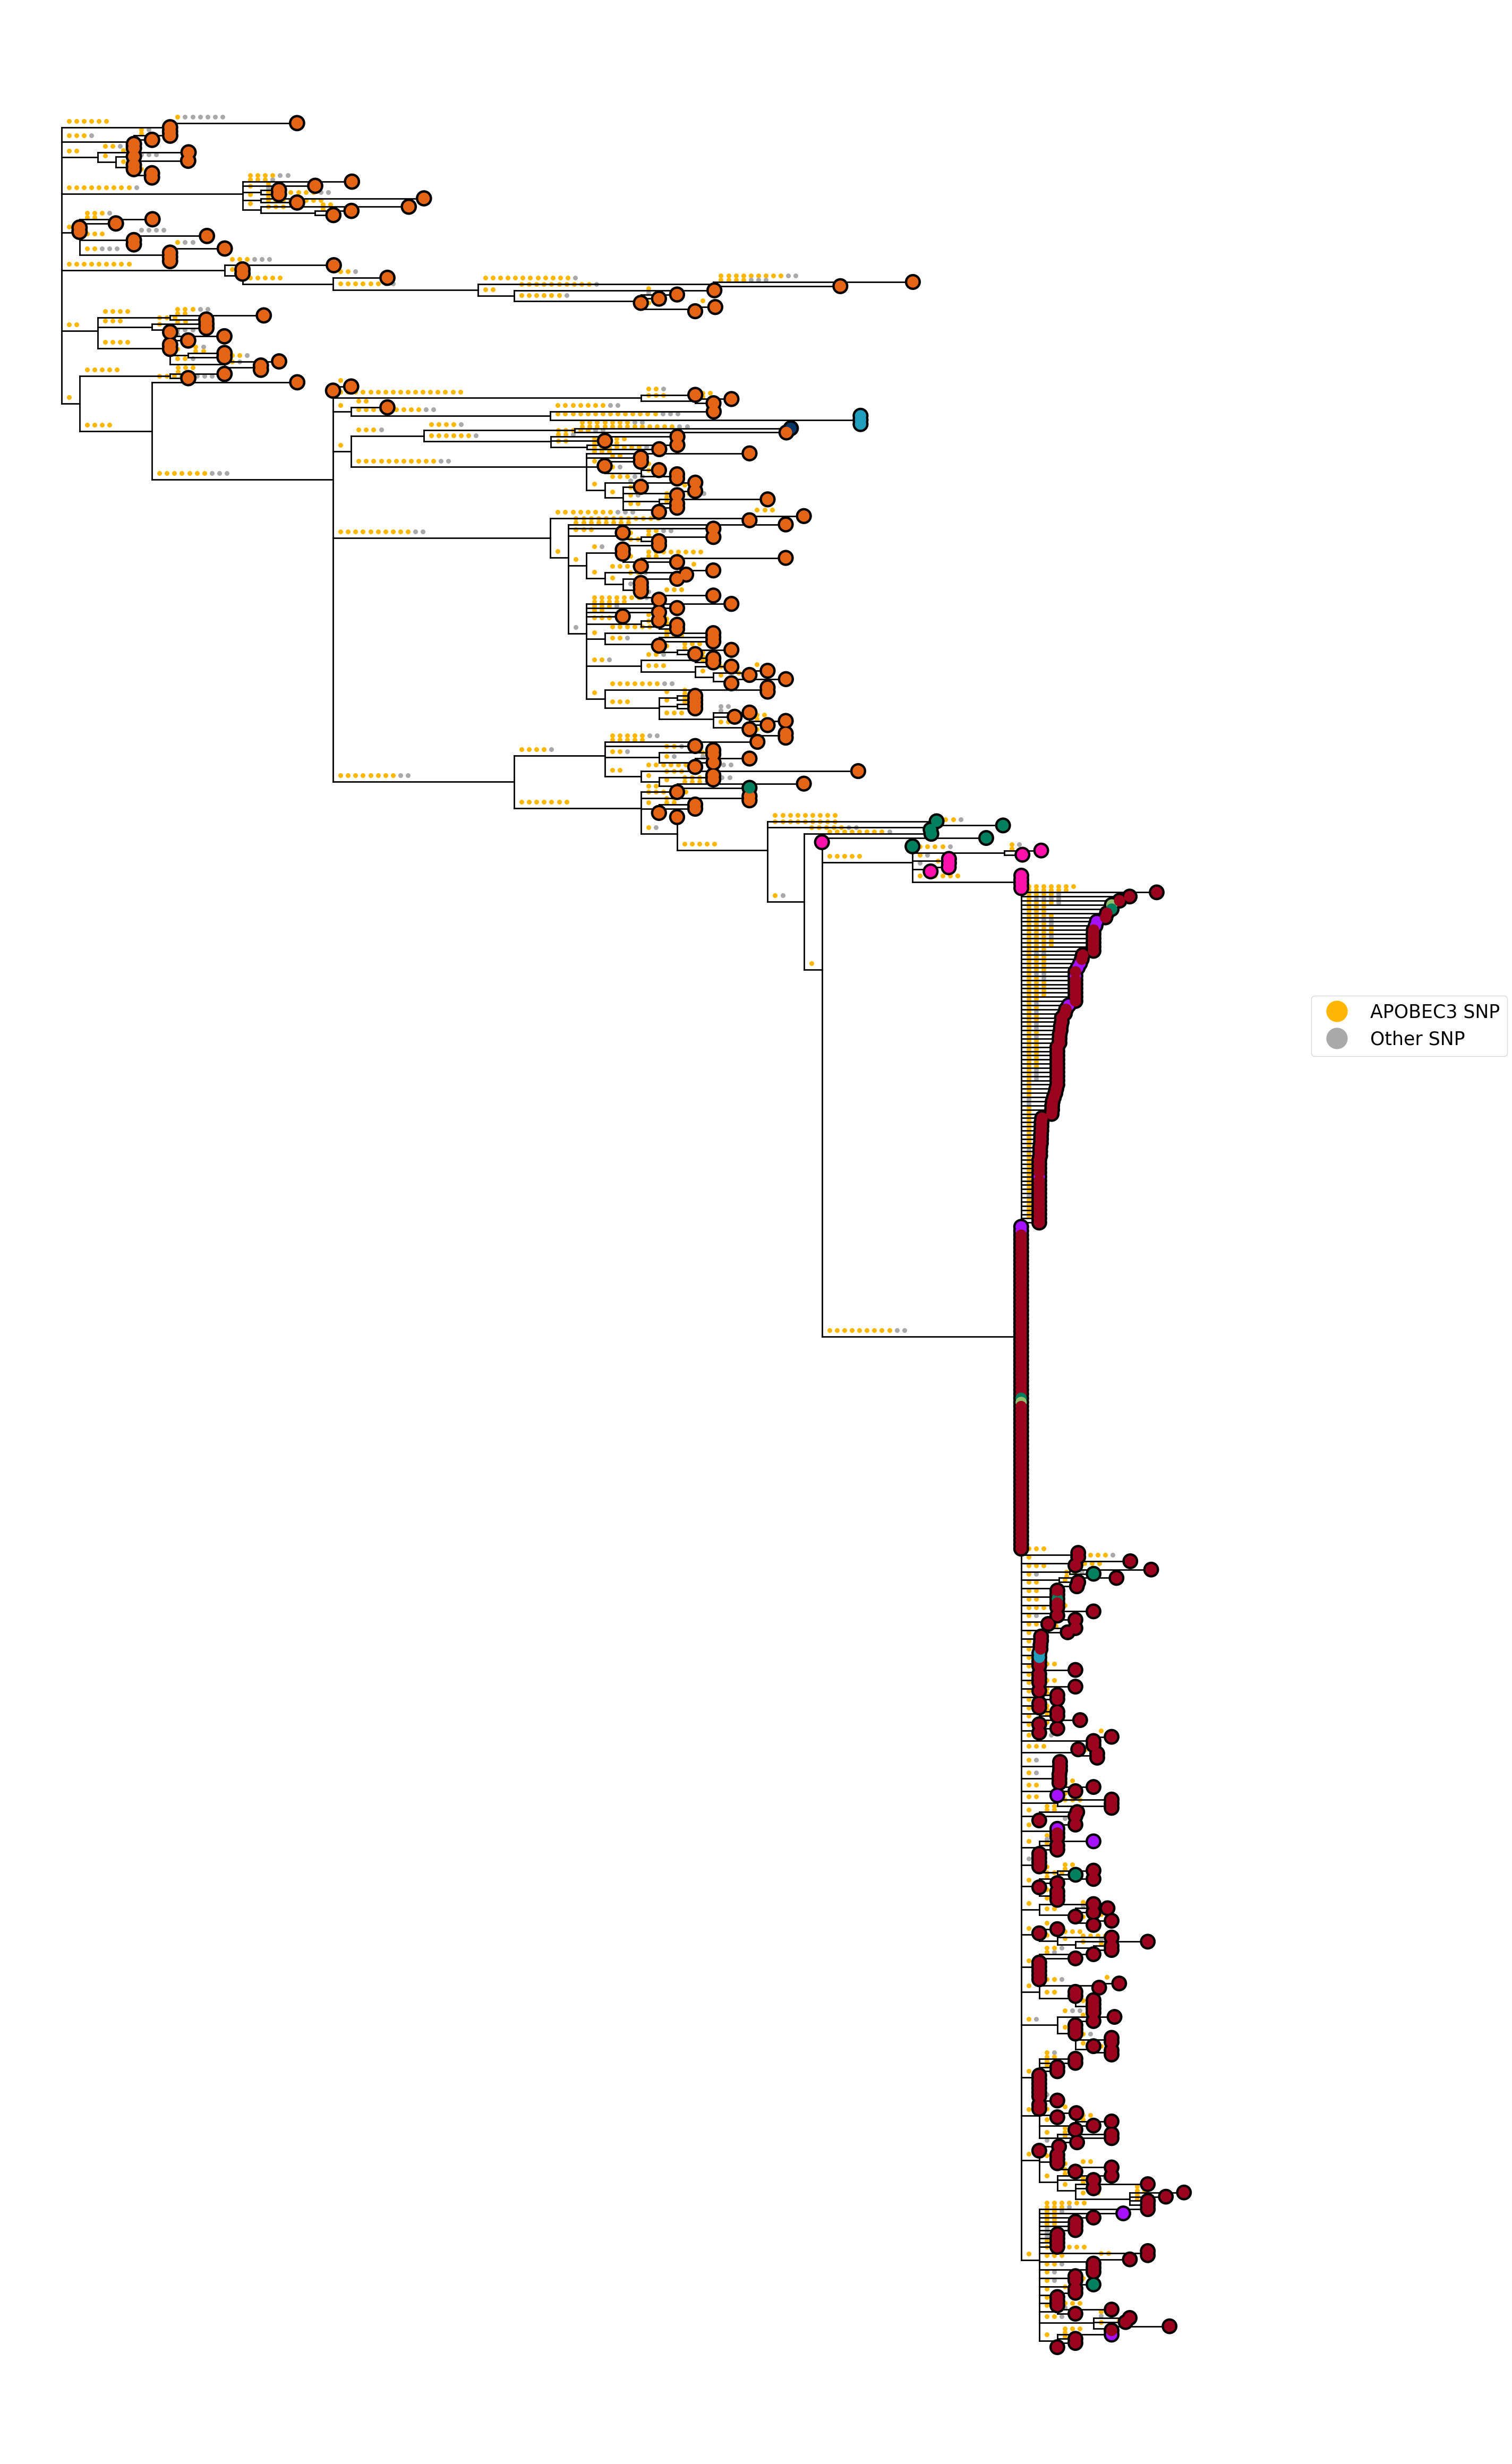

In [16]:
branch_snps = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Final+Mask+SLE+data+25Sept17/Need+Masking+fasta.25aug17.tree.branch_snps.reconstruction.csv"
treefile ="/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Final+Mask+SLE+data+25Sept17/Need+Masking+fasta.25aug17.tree"
make_reconstruction_tree_figure("/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Final+Mask+SLE+data+25Sept17/Complete+SLE.tree",branch_snps,treefile,30,60)